# OpenML Datasets for SG-FIGS: XOR Synergy Verification

This notebook demonstrates the **monks2** dataset from the SG-FIGS (Synergy-Guided FIGS) evaluation suite.

**What it does:**
1. Loads pre-processed monks2 data (601 instances, 6 categorical features)
2. Inspects the dataset structure: class distribution, fold assignments, feature statistics
3. Performs **XOR synergy verification** via mutual information analysis — confirming that pairwise feature interactions carry more information about the target than individual features
4. Visualizes the mutual information results

**Source:** RO-FIGS paper (arxiv 2504.06927) — monks2 is OpenML dataset 334, an XOR synergy benchmark.

In [1]:
%%capture
%pip install -q pandas==2.3.3 scikit-learn==1.7.2 matplotlib==3.10.7

In [2]:
import json
import os
from itertools import combinations
from collections import Counter

import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [3]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-fb8249-synergy-guided-oblique-splits-using-part/main/dataset_iter2_sg_figs_dataset/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Loaded {len(data['datasets'])} dataset(s)")
for ds in data["datasets"]:
    print(f"  - {ds['dataset']}: {len(ds['examples'])} examples")

Loaded 1 dataset(s)
  - monks2: 50 examples


## Configuration

Tunable parameters for fold assignment and mutual information analysis.

In [5]:
# ── Configuration ────────────────────────────────────────────────
N_FOLDS = 5          # Number of cross-validation folds
RANDOM_STATE = 42    # Random seed for reproducibility
# Maximum number of examples to process (None = all available)
MAX_EXAMPLES = None

## Dataset Overview

Parse the JSON examples into a DataFrame and inspect the structure: class distribution, fold assignments, and feature statistics.

In [6]:
# Extract monks2 dataset
monks2_ds = data["datasets"][0]
examples = monks2_ds["examples"]
if MAX_EXAMPLES is not None:
    examples = examples[:MAX_EXAMPLES]

print(f"Dataset: {monks2_ds['dataset']}")
print(f"Examples: {len(examples)}")
print(f"Domain: {examples[0]['metadata_domain']}")
print(f"Features: {examples[0]['metadata_n_features']}")
print(f"Classes: {examples[0]['metadata_n_classes']}")

# Parse JSON input strings into a DataFrame
feature_names = examples[0]["metadata_feature_names"]
rows = []
for ex in examples:
    feat = json.loads(ex["input"])
    feat["target"] = int(ex["output"])
    feat["fold"] = ex["metadata_fold"]
    rows.append(feat)

df = pd.DataFrame(rows)
print(f"\nDataFrame shape: {df.shape}")

# Class distribution
class_counts = df["target"].value_counts().sort_index()
print(f"\nClass distribution:")
for cls, count in class_counts.items():
    print(f"  Class {cls}: {count} ({100*count/len(df):.1f}%)")

# Fold distribution
fold_counts = df["fold"].value_counts().sort_index()
print(f"\nFold distribution:")
for fold, count in fold_counts.items():
    print(f"  Fold {fold}: {count}")

print(f"\nFirst 5 rows:")
df.head()

Dataset: monks2
Examples: 50
Domain: artificial_XOR_benchmark
Features: 6
Classes: 2

DataFrame shape: (50, 8)

Class distribution:
  Class 0: 25 (50.0%)
  Class 1: 25 (50.0%)

Fold distribution:
  Fold 0: 8
  Fold 1: 10
  Fold 2: 10
  Fold 3: 13
  Fold 4: 9

First 5 rows:


,attr1,attr2,attr3,attr4,attr5,attr6,target,fold
0,1,1,2,2,4,1,0,3
1,1,1,2,3,1,2,0,4
2,1,1,2,3,2,2,1,1
3,1,2,1,2,1,2,0,2
4,1,2,1,2,3,1,0,1


## XOR Synergy Verification via Mutual Information

The monks2 target is: **exactly two of six** attributes equal 1 (XOR-like rule).

Individual features should have **low** mutual information (MI) with the target, while **pairwise** feature combinations should show higher MI — confirming the XOR interaction structure that makes this dataset suitable for evaluating synergy-aware methods like SG-FIGS.

In [7]:
# ── XOR Synergy Verification ─────────────────────────────────────
X = df[feature_names].values.astype(int)
y = df["target"].values.astype(int)

# Individual feature MI
print("Individual feature MI with target:")
individual_mi = mutual_info_classif(
    X, y, discrete_features=True, random_state=RANDOM_STATE
)
for fname, mi_val in zip(feature_names, individual_mi):
    print(f"  {fname}: MI = {mi_val:.4f}")
avg_individual = np.mean(individual_mi)

# Pairwise feature MI (create joint categorical features)
print("\nPairwise feature MI (joint categories) with target:")
pair_labels = []
pair_mis = []
for i, j in combinations(range(len(feature_names)), 2):
    # Create joint categorical feature by combining two features
    joint = X[:, i] * 10 + X[:, j]  # unique combo encoding
    joint_mi = mutual_info_classif(
        joint.reshape(-1, 1), y, discrete_features=True, random_state=RANDOM_STATE
    )[0]
    pair_mis.append(joint_mi)
    fname_i, fname_j = feature_names[i], feature_names[j]
    pair_labels.append(f"({fname_i}, {fname_j})")
    print(f"  ({fname_i}, {fname_j}): MI = {joint_mi:.4f}")

avg_pair = np.mean(pair_mis)
max_pair = np.max(pair_mis)
print(f"\nSummary:")
print(f"  Avg individual MI: {avg_individual:.4f}")
print(f"  Avg pairwise MI:   {avg_pair:.4f}")
print(f"  Max pairwise MI:   {max_pair:.4f}")
print(f"  Ratio (pair/indiv): {avg_pair/avg_individual:.1f}x")
if avg_pair > avg_individual:
    print("  ✓ Pairwise MI > Individual MI → confirms XOR interaction structure")
else:
    print("  ⚠ Unexpected: pairwise MI not higher than individual MI")

Individual feature MI with target:
  attr1: MI = 0.0037
  attr2: MI = 0.0313
  attr3: MI = 0.0072
  attr4: MI = 0.0318
  attr5: MI = 0.0829
  attr6: MI = 0.0008

Pairwise feature MI (joint categories) with target:
  (attr1, attr2): MI = 0.1646
  (attr1, attr3): MI = 0.0397
  (attr1, attr4): MI = 0.0988
  (attr1, attr5): MI = 0.2307
  (attr1, attr6): MI = 0.0561
  (attr2, attr3): MI = 0.0833
  (attr2, attr4): MI = 0.1029
  (attr2, attr5): MI = 0.2309
  (attr2, attr6): MI = 0.0507
  (attr3, attr4): MI = 0.0495
  (attr3, attr5): MI = 0.1541
  (attr3, attr6): MI = 0.0241
  (attr4, attr5): MI = 0.1638
  (attr4, attr6): MI = 0.0485
  (attr5, attr6): MI = 0.1191

Summary:
  Avg individual MI: 0.0263
  Avg pairwise MI:   0.1078
  Max pairwise MI:   0.2309
  Ratio (pair/indiv): 4.1x
  ✓ Pairwise MI > Individual MI → confirms XOR interaction structure


## Visualization

**Left:** Individual vs. pairwise mutual information — bar chart showing the MI gap that reveals XOR synergy.
**Right:** Class distribution across the 5 cross-validation folds.

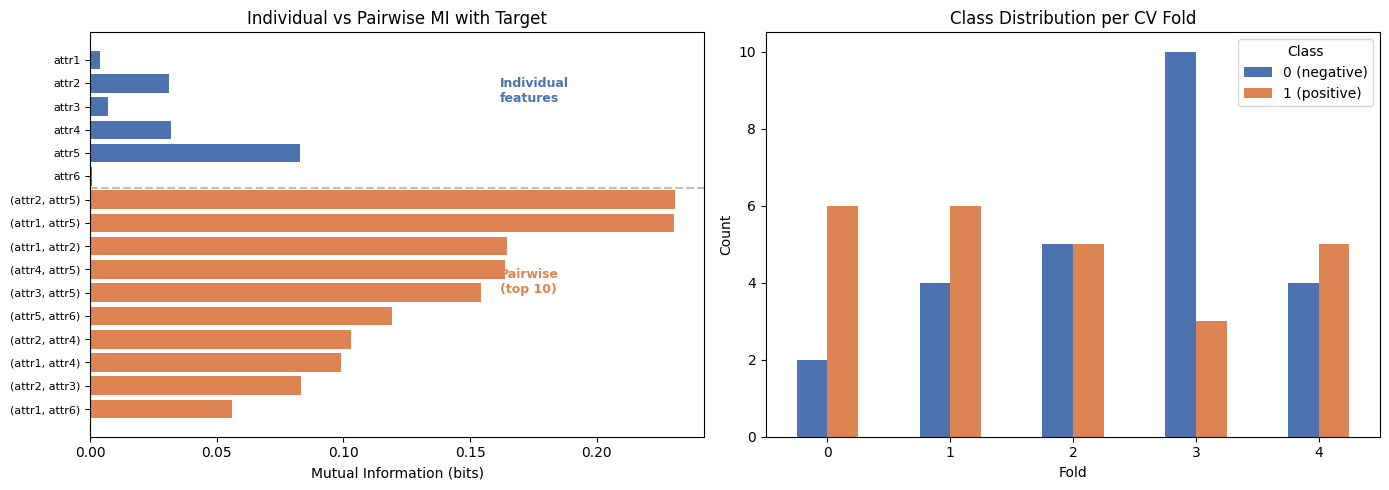


SUMMARY: monks2 XOR Synergy Analysis
  Examples analyzed:     50
  Features:              6
  Avg individual MI:     0.0263
  Avg pairwise MI:       0.1078
  Synergy ratio:         4.1x
  XOR structure confirmed: Yes


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ── Left: MI comparison ─────────────────────────────────────────
ax = axes[0]
# Sort pairwise MIs for better visualization
sorted_idx = np.argsort(pair_mis)[::-1]
top_n = min(10, len(pair_mis))  # Show top 10 pairs
top_pair_labels = [pair_labels[i] for i in sorted_idx[:top_n]]
top_pair_mis = [pair_mis[i] for i in sorted_idx[:top_n]]

# Combine individual + top pairwise
all_labels = feature_names + top_pair_labels
all_mis = list(individual_mi) + top_pair_mis
colors = ["#4C72B0"] * len(feature_names) + ["#DD8452"] * top_n

bars = ax.barh(range(len(all_labels)), all_mis, color=colors)
ax.set_yticks(range(len(all_labels)))
ax.set_yticklabels(all_labels, fontsize=8)
ax.set_xlabel("Mutual Information (bits)")
ax.set_title("Individual vs Pairwise MI with Target")
ax.axhline(y=len(feature_names) - 0.5, color="gray", linestyle="--", alpha=0.5)
ax.text(max(all_mis) * 0.7, len(feature_names) * 0.3, "Individual\nfeatures",
        fontsize=9, color="#4C72B0", fontweight="bold")
ax.text(max(all_mis) * 0.7, len(feature_names) + top_n * 0.4, "Pairwise\n(top 10)",
        fontsize=9, color="#DD8452", fontweight="bold")
ax.invert_yaxis()

# ── Right: Class distribution per fold ───────────────────────────
ax = axes[1]
fold_class = df.groupby(["fold", "target"]).size().unstack(fill_value=0)
fold_class.plot(kind="bar", ax=ax, color=["#4C72B0", "#DD8452"])
ax.set_xlabel("Fold")
ax.set_ylabel("Count")
ax.set_title("Class Distribution per CV Fold")
ax.legend(title="Class", labels=["0 (negative)", "1 (positive)"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

# ── Summary statistics ───────────────────────────────────────────
print(f"\n{'='*50}")
print(f"SUMMARY: monks2 XOR Synergy Analysis")
print(f"{'='*50}")
print(f"  Examples analyzed:     {len(examples)}")
print(f"  Features:              {len(feature_names)}")
print(f"  Avg individual MI:     {avg_individual:.4f}")
print(f"  Avg pairwise MI:       {avg_pair:.4f}")
print(f"  Synergy ratio:         {avg_pair/avg_individual:.1f}x")
print(f"  XOR structure confirmed: {'Yes' if avg_pair > avg_individual else 'No'}")
print(f"{'='*50}")